In [8]:
import unicodedata
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import textstat

from matplotlib.ticker import PercentFormatter
from tqdm.notebook import tqdm

from textblob import TextBlob
from textblob_nl import PatternAnalyzer

# set language to dutch 
textstat.set_lang("nl")

# progress bar when apply functions to dataframe
tqdm.pandas()

# better quality plots
%config InlineBackend.figure_format = "retina"

In [9]:
TITLE_SIZE = 14

# Text Mining Dutch News Articles

In this article, I analyze Dutch news articles. I gathered the news articles by scraping them from the NOS [website](https://nos.nl/). The NOS is one of the organizations of the public broadcasting system in the Netherlands and established in the Media Act. Its task is to provide the media supply for the national public media service in the field of news, sports, and events. The NOS is also one of the biggest online news websites in the Netherlands.

As of the publishing of this post, the dataset contains 218,609 news articles spanning more than 10 years (the first article in the archive is published on 2020-01-01). In addition to the article content, the dataset contains the article title, the category, and the publishing grade. The NOS also publishes liveblogs. I do not consider these news articles. Therefore they are excluded from the dataset.

Before analyzing the news articles, the raw data needs to be cleaned. The texts contain a lot of white spaces and some weird characters. I use regular expressions and some Python string methods to remove extra white spaces and these wrong characters.

Most of the analysis focuses on the differences between article features based on the category they are classified as.

[leeswijzer]

In [10]:
# Get data
nos_df = (pd.read_csv("nos_archief.csv", parse_dates=["datetime"], encoding="utf-8") 
          # sort values by date published
          .sort_values("datetime")
          # draw raw date colum
          # .drop(columns="raw_date")
          ) 

# Convert category colum to category
nos_df.category = pd.Categorical(nos_df.category)

In [36]:
nos_df.shape

(218609, 13)

In [11]:
# lambda function to clean multiple spaces and non-breaking spaces
def clean_string(x):
    x = re.sub(" +", " ", x)
    x = x.replace("\n", " ")
    x = unicodedata.normalize("NFKD", x)
    return x

# clean content 
nos_df.content = nos_df.content.progress_apply(clean_string)

# clean title
nos_df.title = nos_df.title.progress_apply(clean_string)

In [12]:
nos_df.content.iloc[1]

'Spanje is met ingang van vandaag voorzitter van de EU. De Zweedse premier Fredrik Reinfeldt heeft het stokje, formeel om middernacht, overgedragen aan zijn Spaanse collega José Luis Rodriguez Zapatero.  Spanje is het eerste land dat het roulerend voorzitterschap overneemt onder het Verdrag van Lissabon, dat op 1 december in werking is getreden. Nieuwe functies  De rol van het voorzitterschap is met het in werking treden van het Verdrag van Lissabon veranderd. Voortaan zal de Belg Herman van Rompuy de vergaderingen van de Europese Raad voorzitten. Van Rompuy vertegenwoordigt de EU ook internationaal, samen met de Britse Catherine Ashton. Zij is de buitenlandminister van de EU, ook een nieuwe functie. Spanje heeft het economisch herstel hoog op de agenda van de Europese Unie gezet. Van Rompuy organiseert volgende maand een extra EU-top over de aanpak van de economische crisis. Geslaagd De Zweden mogen terugzien op een geslaagd voorzitterschap. In het afgelopen half jaar kwam het nieuwe

In [13]:
# Get unique categories
categories = nos_df['category'].unique().tolist()

# Category labels to English
translate_categories = {
    "Buitenland": "Foreign",
    "Binnenland": "Domestic",
    "Politiek": "Politics",
    "Economie": "Economy",
    "Koningshuis": "Royal family",
    "Opmerkelijk": "Remarkable",
    "Tech": "Tech",
    "Cultuur & Media": "Culture & Media",
    "Regionaal nieuws": "Regional news"
}

# Map category labels
nos_df["category_en"] = nos_df.category.map(translate_categories)

## Article Counts

The first thing to look at is the article count over time between 2010 and 2020. To get a less stochastic article count, I decided to group them by months over time. From 2010 to the middle of 2016, the monthly article count increased from around 1000 to a little more than 2000. After 2016 we see a downwards trend in the number of monthly articles published to 1100 in 2020.

In [14]:
# Function that groups times series
def group_timeseries(df, column, normalize=False, count=False):
    # Group by year and month and select colimn
    group = df.groupby([df.datetime.dt.year, df.datetime.dt.month])[column]

    # Value count and unstack to dataframe
    if count:
        df = group.value_counts(normalize=normalize).unstack()

    # Count 
    else:
        df = group.count()

    # Select year and month index
    years = pd.Series(df.index.get_level_values(level=0).values.astype(str))
    months = pd.Series(df.index.get_level_values(level=1).values.astype(str))

    # Combine year and month to new date
    dates = pd.to_datetime(years + "-" + months)

    # Set date as index
    df = df.reset_index(drop=True)
    df.index = dates

    return df

# Overall absolute count over articles
all_overtime = group_timeseries(nos_df, "category_en", count=False)

# Get absolute and normalized grouped time series
cat_timeseries_absolute = group_timeseries(nos_df, "category_en", count=True)
cat_timeseries_normalized = group_timeseries(nos_df, "category_en", normalize=True, count=True)

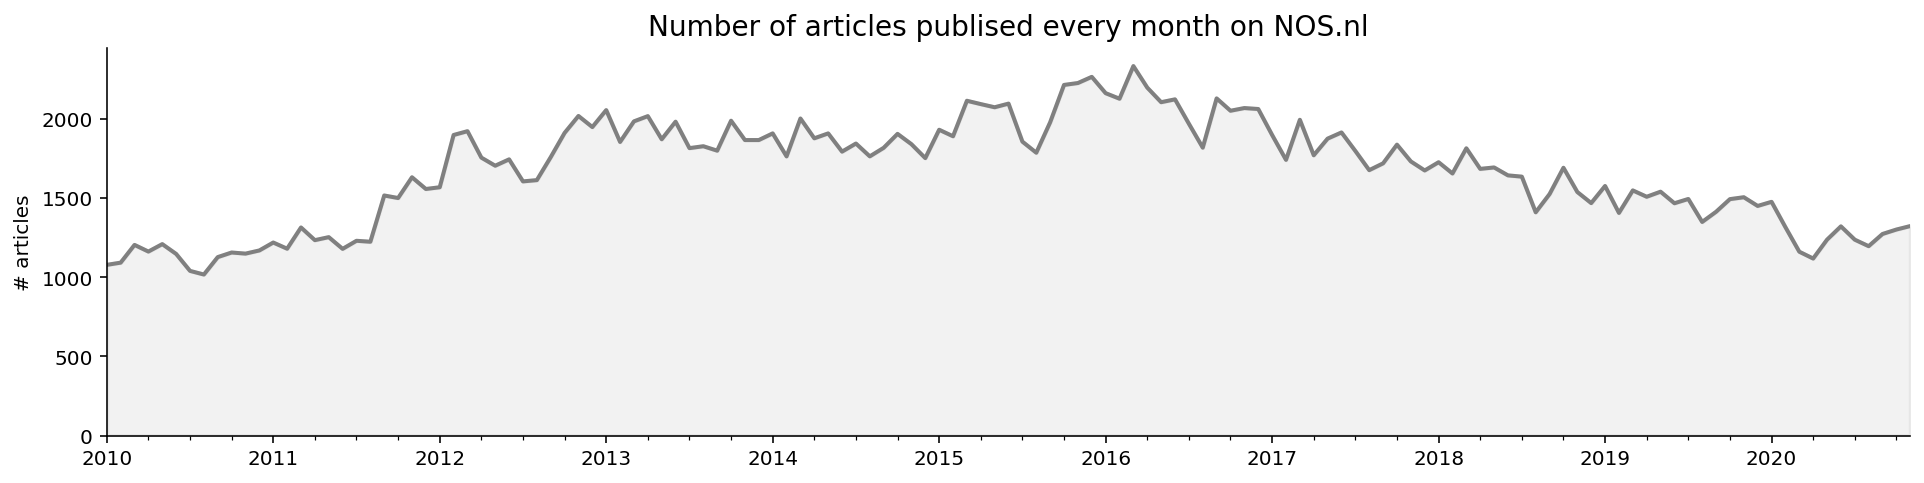

In [15]:
# Intialize figure
fig, ax = plt.subplots(figsize=(14, 4), nrows=1)

# Plot absolute number of acticles over time
all_overtime.plot(ax=ax, legend=None, lw=2, color="gray")
all_overtime.plot(kind="area", ax=ax, legend=None, lw=2, alpha=0.1, color="gray")
ax.set_title("Number of articles publised every month on NOS.nl", fontsize=TITLE_SIZE)
ax.set_ylabel("# articles")
ax.set_ylim(0)

# Despine and tightlayout
sns.despine()
fig.tight_layout(pad=3)

More interesting is probably to look at the change of monthly article count when we split the articles based on category. If we look at the absolute count over time, we see the same trend as the overall article count. This is most likely caused by the "Binnenland" (domestic) and the "Buitenland" (foreign) categories, which display the same tends.

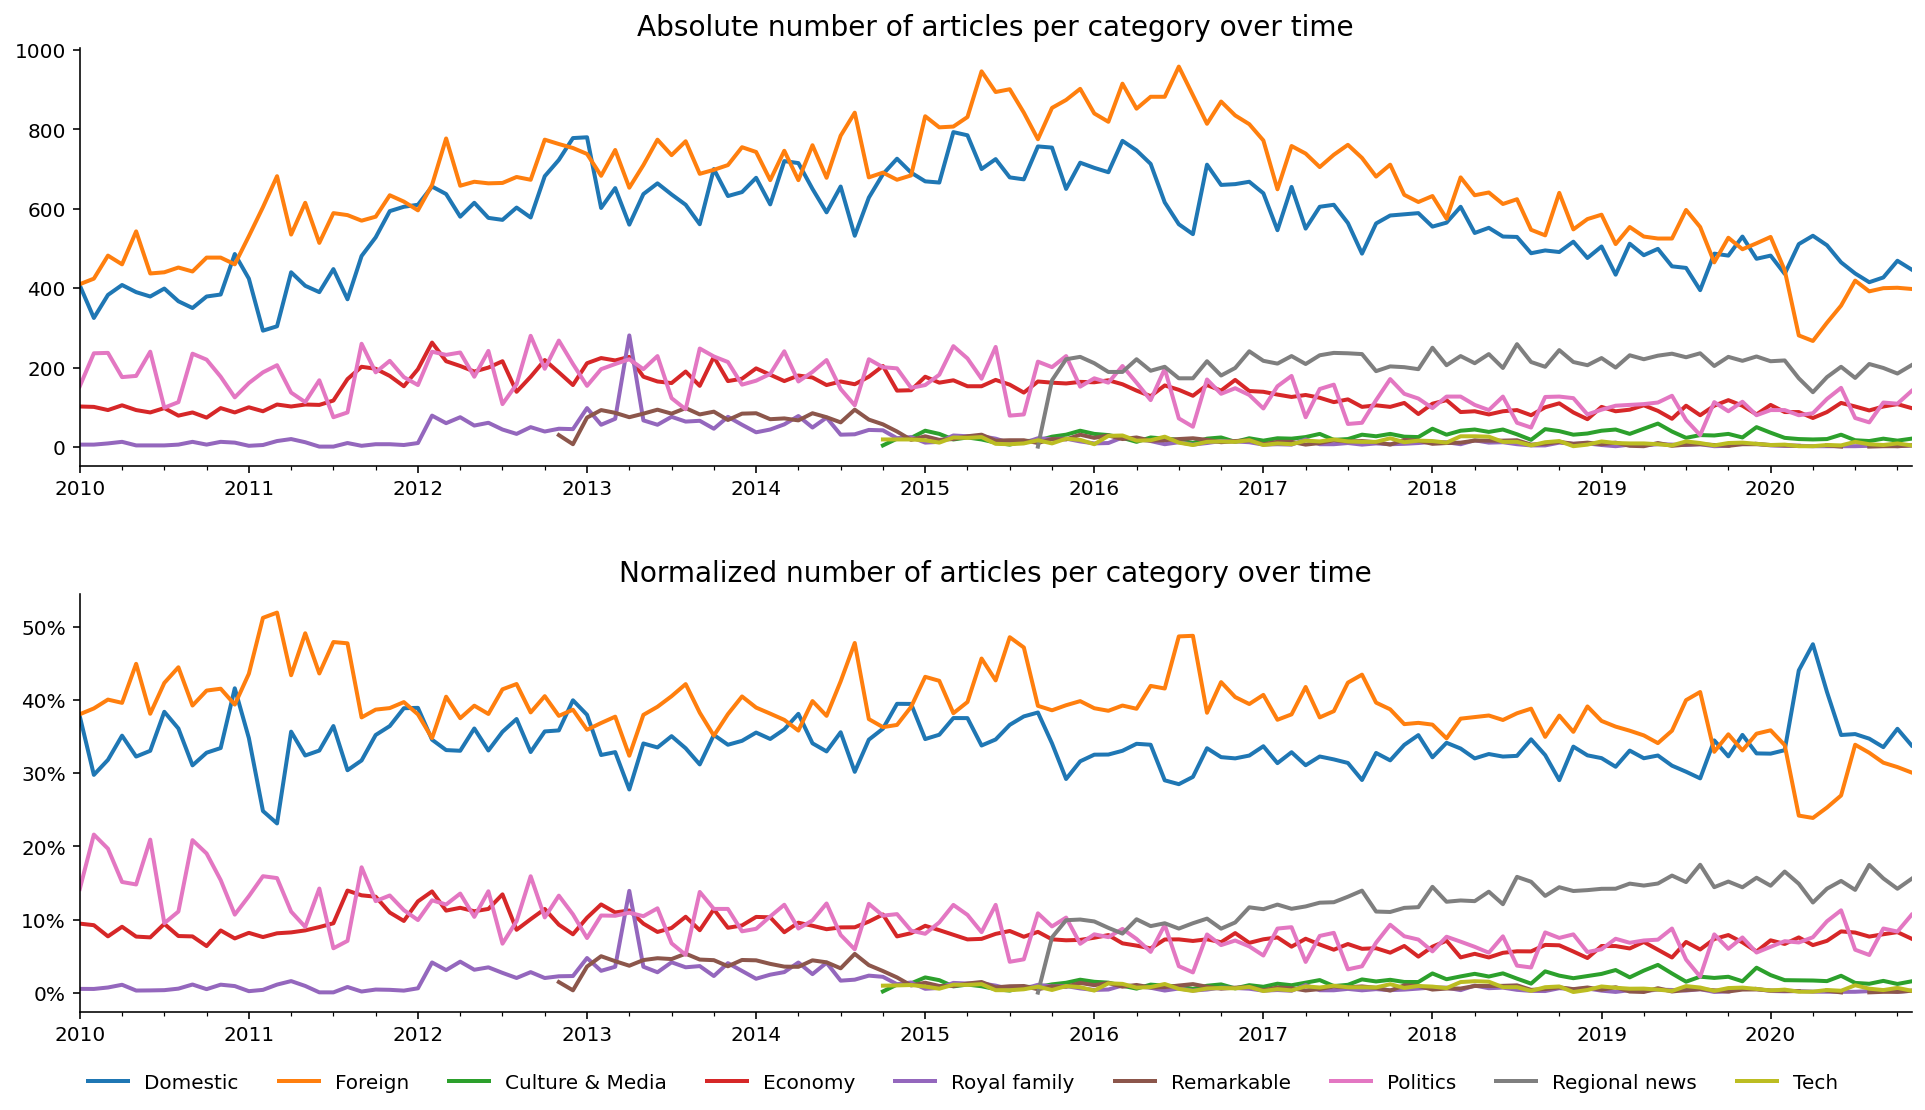

In [16]:
# Intialize figure
fig, ax = plt.subplots(figsize=(14, 8), nrows=2)

# Figure 1: Absolute number of acticles per category
(cat_timeseries_absolute
 .plot(lw=2,
       ax=ax[0],
       legend=None))
ax[0].set_title("Absolute number of articles per category over time", fontsize=TITLE_SIZE)

# Figure 2: Normalized number of acticles per category
(cat_timeseries_normalized
 .plot(lw=2, 
       legend=None, 
       ax=ax[1]) )
ax[1].set_title("Normalized number of articles per category over time", fontsize=TITLE_SIZE)

# Format yaxis ticks as percent
ax[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))

# Only one legend for both axes
handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, ncol=10, loc="lower center")

# Despine and tightlayout
sns.despine()
fig.tight_layout(pad=3)

Therefore I choose to normalize the counts based on category. The second graph shows the share of a news category in the total number of articles in a specific month. For example, there is a large bump in the domestic news share (and drop in foreign news) in the first quarter of 2020 caused by the initial Coronavirus outbreak. In contrast, most of 2011, the foreign news articles were most prevalent, probably caused by the start of the [Arabic Spring](https://en.wikipedia.org/wiki/Arab_Spring#:~:text=The%20Arab%20Spring%20(Arabic%3A%20%D8%A7%D9%84%D8%B1%D8%A8%D9%8A%D8%B9,starting%20with%20protests%20in%20Tunisia.), the [capture of Osama Binladen](https://en.wikipedia.org/wiki/Killing_of_Osama_bin_Laden), and the [terrorist attacks in Norway](https://en.wikipedia.org/wiki/2011_Norway_attacks).

## Word Count

The word count of an article can be an indicator of the quality of the news article. {% cite blumenstock %} Blumenstock et al. show that longer Wikipedia articles are more likely of better quality. Longer articles are more often featured than shorter Wikipedia articles. They state that word count is a robust method of article quality.

Let us first look at the overall word count of all the articles published by the NOS. As expected, the word count of the article is heavily right-skewed (when used for modeling probably better to use the log). Also, the word count of the title is more normally distributed, which is expected.

In [17]:
# Calculate word count of title and article
nos_df["title_word_count"] = nos_df["title"].str.split(" ").str.len()
nos_df["content_word_count"] = nos_df["content"].str.split(" ").str.len()

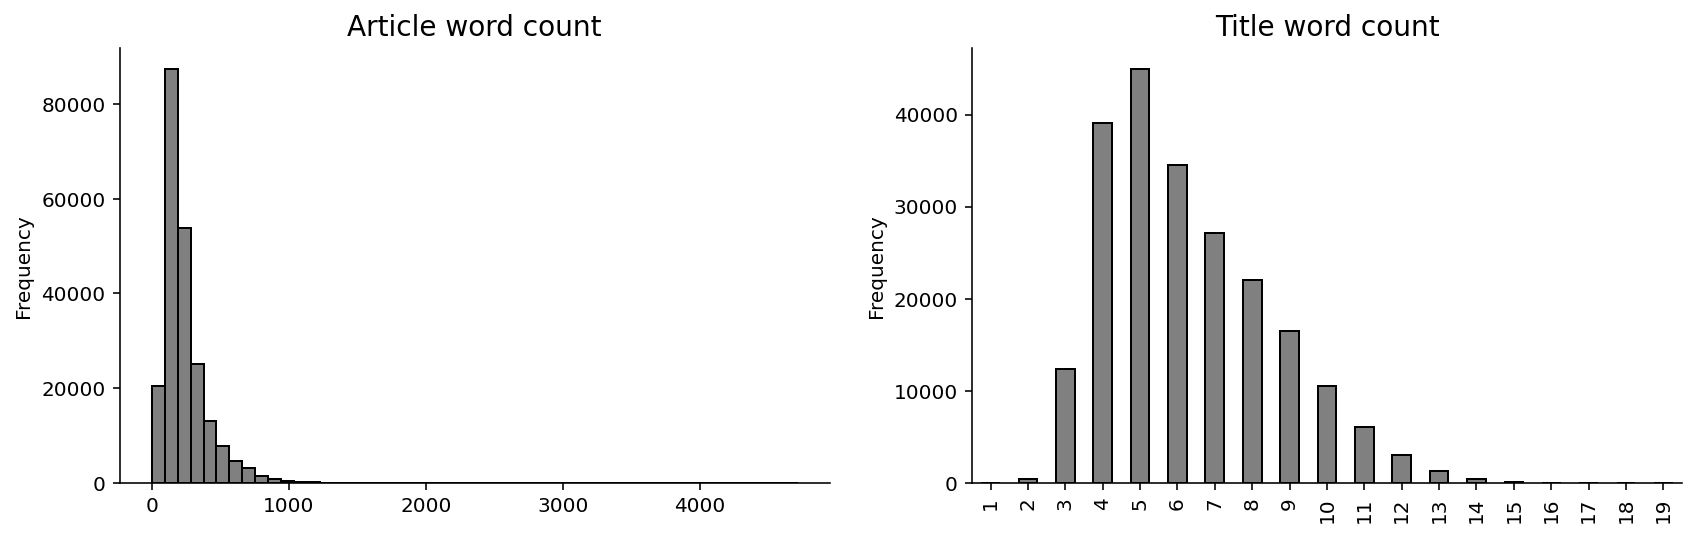

In [18]:
# Initialze figure
fig, ax = plt.subplots(figsize=(14, 4), ncols=2)

# Plot article word count distribution
nos_df.content_word_count.plot(kind='hist', bins=50, ax=ax[0], edgecolor="k", color="gray")
ax[0].set_title("Article word count", fontsize=TITLE_SIZE)

# Plot article title word count distribution
nos_df.title_word_count.value_counts().sort_index().plot(kind='bar', ax=ax[1], edgecolor="k", ylabel="Frequency", color="gray")
ax[1].set_title("Title word count", fontsize=TITLE_SIZE)

# Despine
sns.despine();

Tech and Culture & Media have the highest median word count. This makes sense to me. These articles are often less time-dependent. Meaning that their publishing is less dependent on the daily news cycle. They are still relevant at a later moment than political news. This suggests that writers have more time to write these articles, can incorporate more detail, leading to longer pieces. The "remarkable" and "regional news" category have the lowest median news count. This is expected most of these articles report small news events, leading to shorter pieces.

In [19]:
categories_en = nos_df['category_en'].unique().tolist()

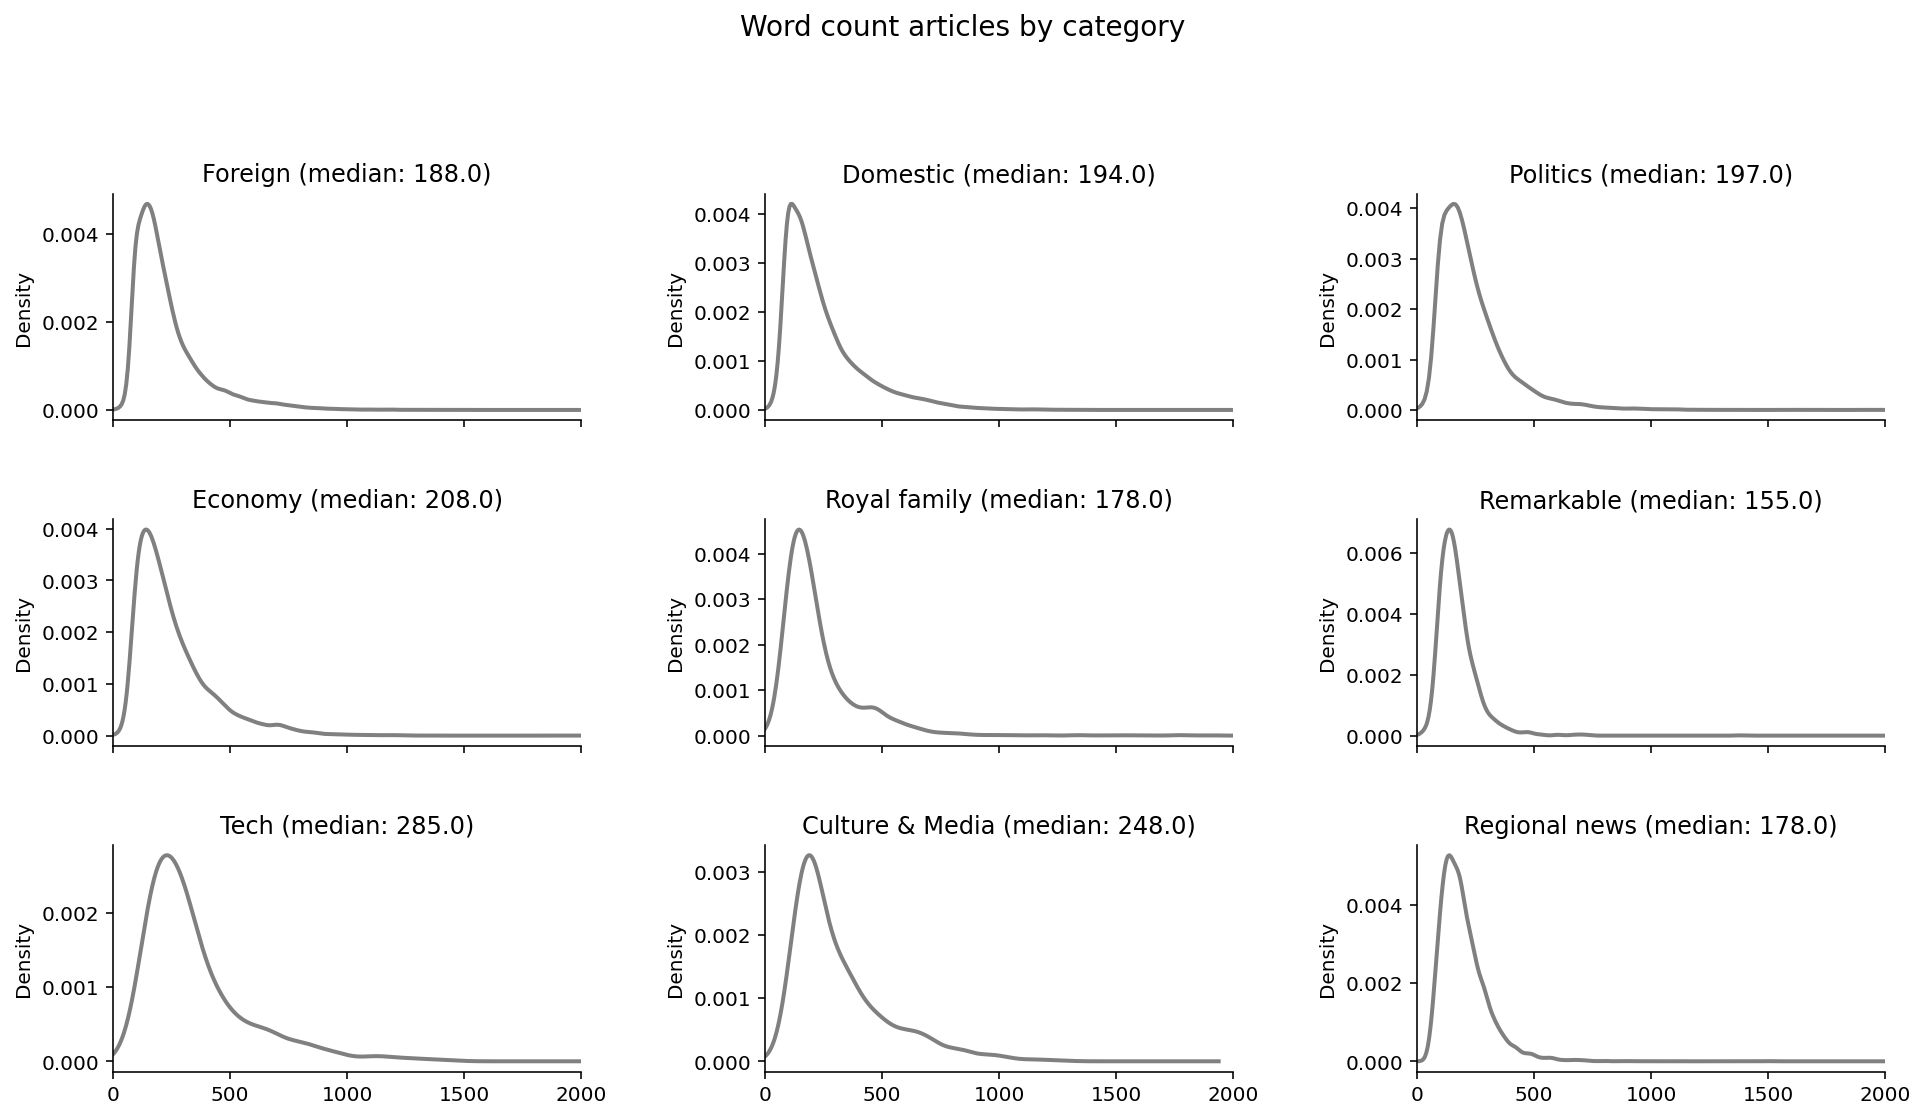

In [20]:
# Initialize plots
fig, axes = plt.subplots(3, 3, figsize=(14, 8), sharex=True)

# Loop over axes and plot category
for cat, ax in enumerate(axes.flatten()):

    # Select df with dataframe
    category_df = nos_df[nos_df.category_en == categories_en[cat]].content_word_count

    # Bar plot word count category
    category_df.plot(kind="kde", ax=ax, title=f"{categories_en[cat]} (median: {category_df.median()})", color="gray", lw=2)

    # Limit x axise
    ax.set_xlim(0, 2000)

# Plot meta data
fig.suptitle("Word count articles by category", fontsize=TITLE_SIZE, y=1)
fig.tight_layout(pad=3)

sns.despine();

## Readability

Another important of a news article is how easy it is to read. Readability measures how hard it is to read a text. There are several methods to calculate readability. These methods are not that reliable, but they give some insight into the readability of a written text. In this analysis, I use the Flesch reading-ease test to calculate readability. Douma {% cite douma_1960 %} slightly tweaked the values in the Flesch reading-ease test formula such that the measures can also be used for Dutch texts.

<details>
  <summary><b>The Flesch-Douma formula </b></summary>
  The Flesch-Douma formula {% cite douma_1960 %} equates readability to the following formula:
  $$ \text{readability} = 206.835 - 0.93 \bigg{(}\frac{\text{total words}}{\text{total sentences}}\bigg{)} - 77.0 \bigg{(}\frac{\text{total syllables}}{\text{total words}}\bigg{)}$$
</details>

The readability score is related to education level.

| Score  | School level       | Notes                                                                   |
|--------|--------------------|-------------------------------------------------------------------------|
| 100–90 | 5th grade          | Very easy to read. Easily understood by an average 11-year-old student. |
| 90–80  | 6th grade          | Easy to read. Conversational English for consumers.                     |
| 80-70  | 7th grade          | Fairly easy to read.                                                    |
| 70-60  | 8th & 9th grade    | Plain English. Easily understood by 13- to 15-year-old students.        |
| 60-50  | 10th to 12th grade | Fairly difficult to read.                                               |
| 50-30  | College            | Difficult to read.                                                      |
| 30-10  | College graduate   | Very difficult to read. Best understood by university graduates.        |
| 10-0   | Professional       | Extremely difficult to read. Best understood by university graduates.   |

The articles categorized as Foreign, Politics, Tech, and Economy are the heardest to read with a readability score below 60, which is about 10th to 12th-grade-level reading.  So somewhat hard to read.  Categories "remarkable news", "regional news" and "culture & media" are easier to read with a score above 60. However, the overall median scores are not that different across categories.


In [21]:
flesh_reading_ease = lambda x: textstat.flesch_reading_ease(str(x))
nos_df["content_flesh_reading_ease"]  = nos_df.content.progress_apply(flesh_reading_ease)

In [22]:
# filter scores
reading = nos_df[(nos_df.content_flesh_reading_ease > 0) & (nos_df.content_flesh_reading_ease < 150)]

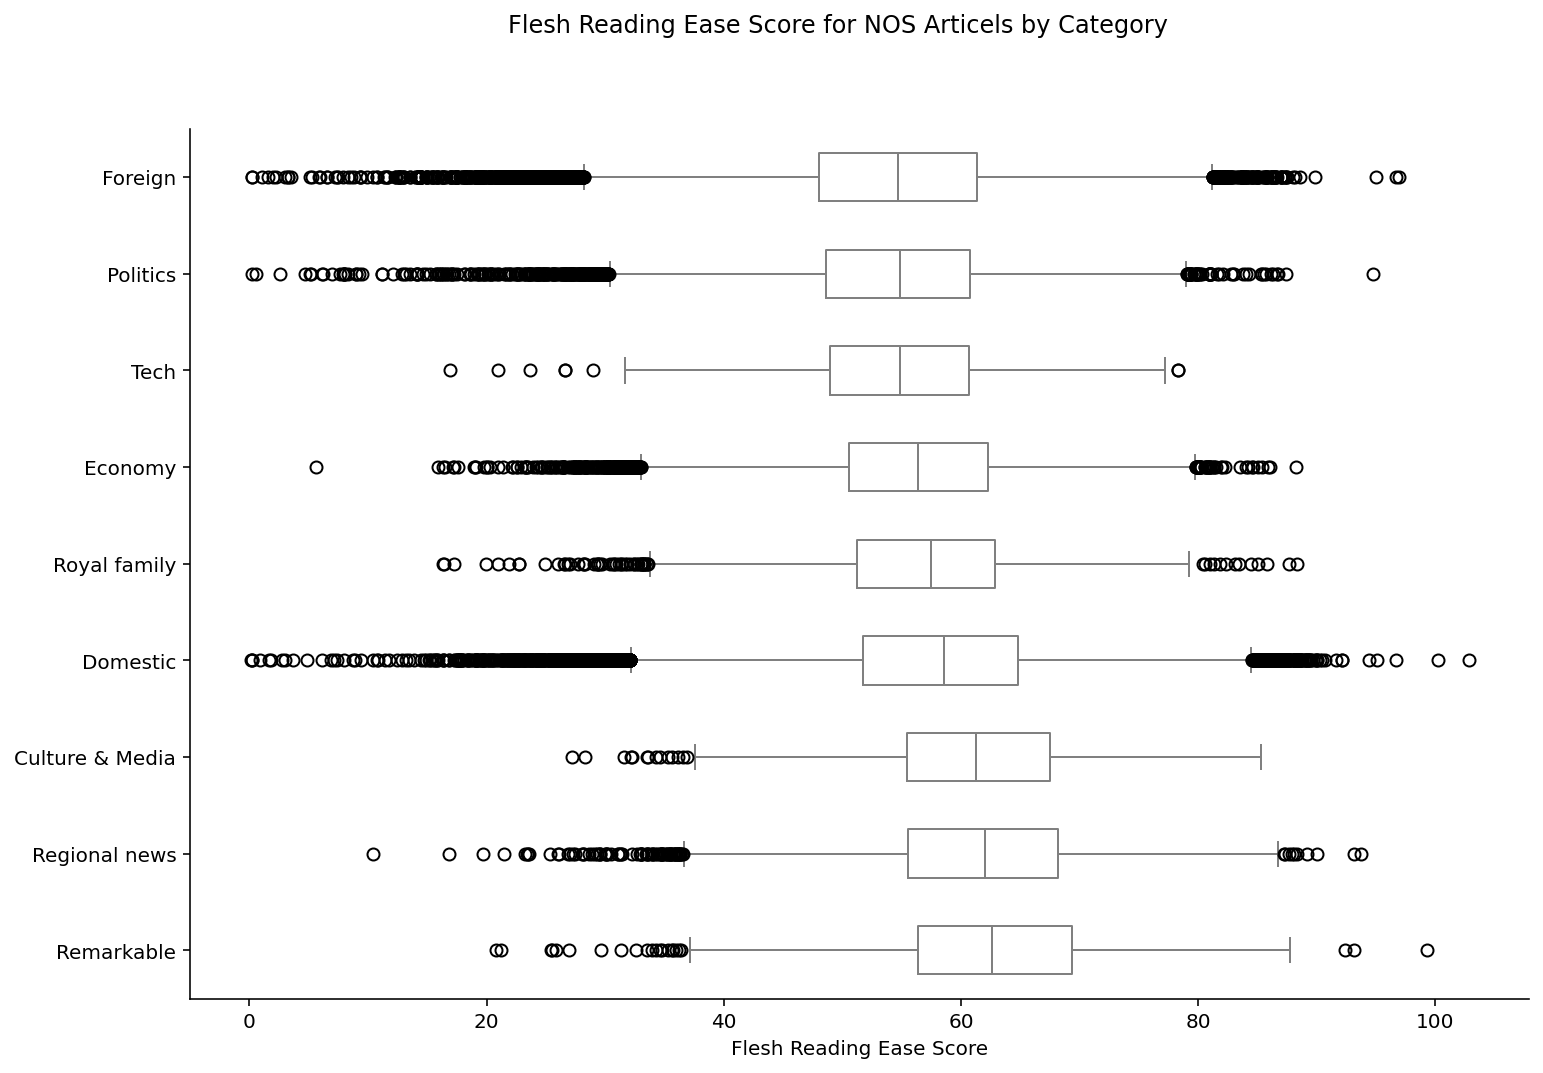

In [23]:
# Get column order sorted by median
order = reading.groupby(["category_en"])[["content_flesh_reading_ease"]].median().unstack().sort_values(ascending=False).index
reading_order = reading[["category_en", "content_flesh_reading_ease"]].pivot(columns="category_en")[order]["content_flesh_reading_ease"]

# Boxplot
reading_order.boxplot(grid=False, figsize=(12, 8), vert=False, color="gray")

# Meta data
plt.suptitle("Flesh Reading Ease Score for NOS Articels by Category")
plt.xlabel("Flesh Reading Ease Score")
sns.despine();

## Sentiment, Polarity, and Subjectivity

Let us look at the sentiment of the texts. Are they positive or negative? Furthermore, we can also analyze the texts for subjectivity. When looking at all the articles together, we see that most of the news articles are neutral in their polarity. Most of the articles hover somewhere in the middle between subjective and objective in their subjectivity measure.

In [24]:
# Extract sentiment
nos_df["sentiment"] = nos_df.content.progress_apply(lambda x: tuple(TextBlob(text=x, analyzer=PatternAnalyzer()).sentiment))

In [25]:
# Get polarity from tuple 
nos_df["polarity"] = nos_df["sentiment"].str.get(0)

# Get subjectivity from tuple 
nos_df["subjectivity"] = nos_df["sentiment"].str.get(1)

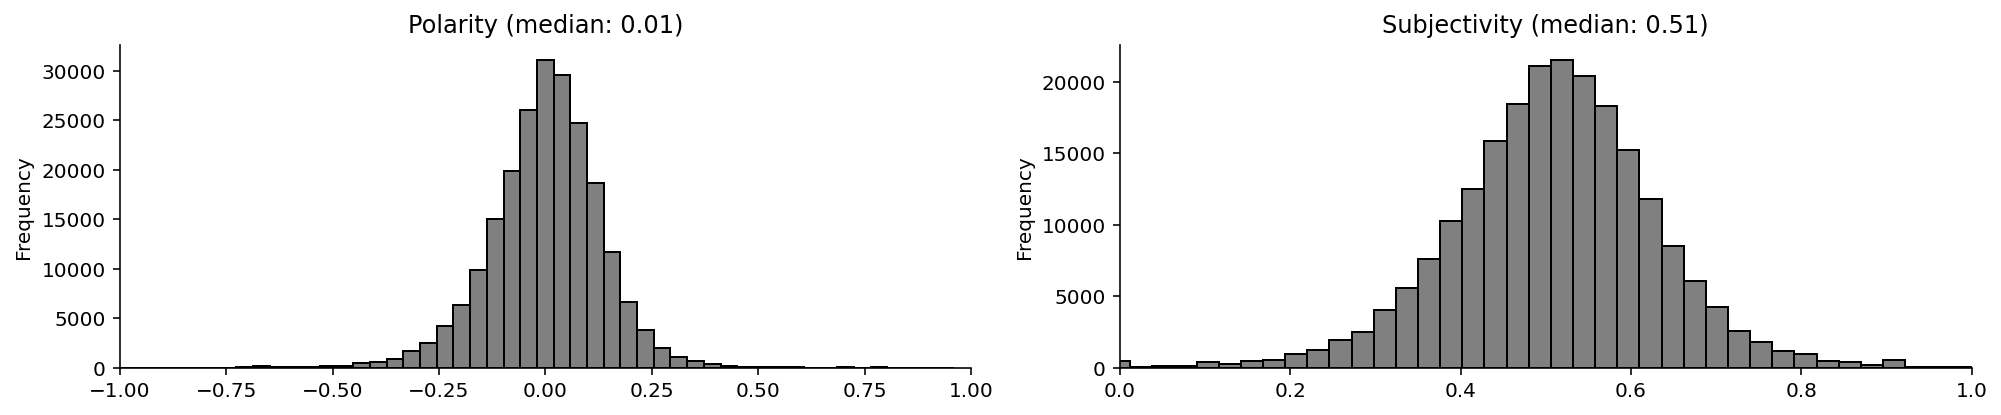

In [26]:
# Initialze figure
fig, ax = plt.subplots(figsize=(14, 3), ncols=2)

# Plot polarity
nos_df["polarity"].plot(kind="hist", bins=50, edgecolor="k", color="gray", ax=ax[0], title=f"Polarity (median: {nos_df.polarity.median():.2f})")

# Plot subjectivity
nos_df["subjectivity"].plot(kind="hist", bins=50, edgecolor="k", color="gray", ax=ax[1], title=f"Subjectivity (median: {nos_df.subjectivity.median():.2f})")

# Limits
ax[0].set_xlim(-1, 1)
ax[1].set_xlim(0, 1)

# Meta-data plot
fig.tight_layout()
sns.despine()

Even if we parse the articles by news category we do not see many differences in the distributions of polarity and subjectivity scores.

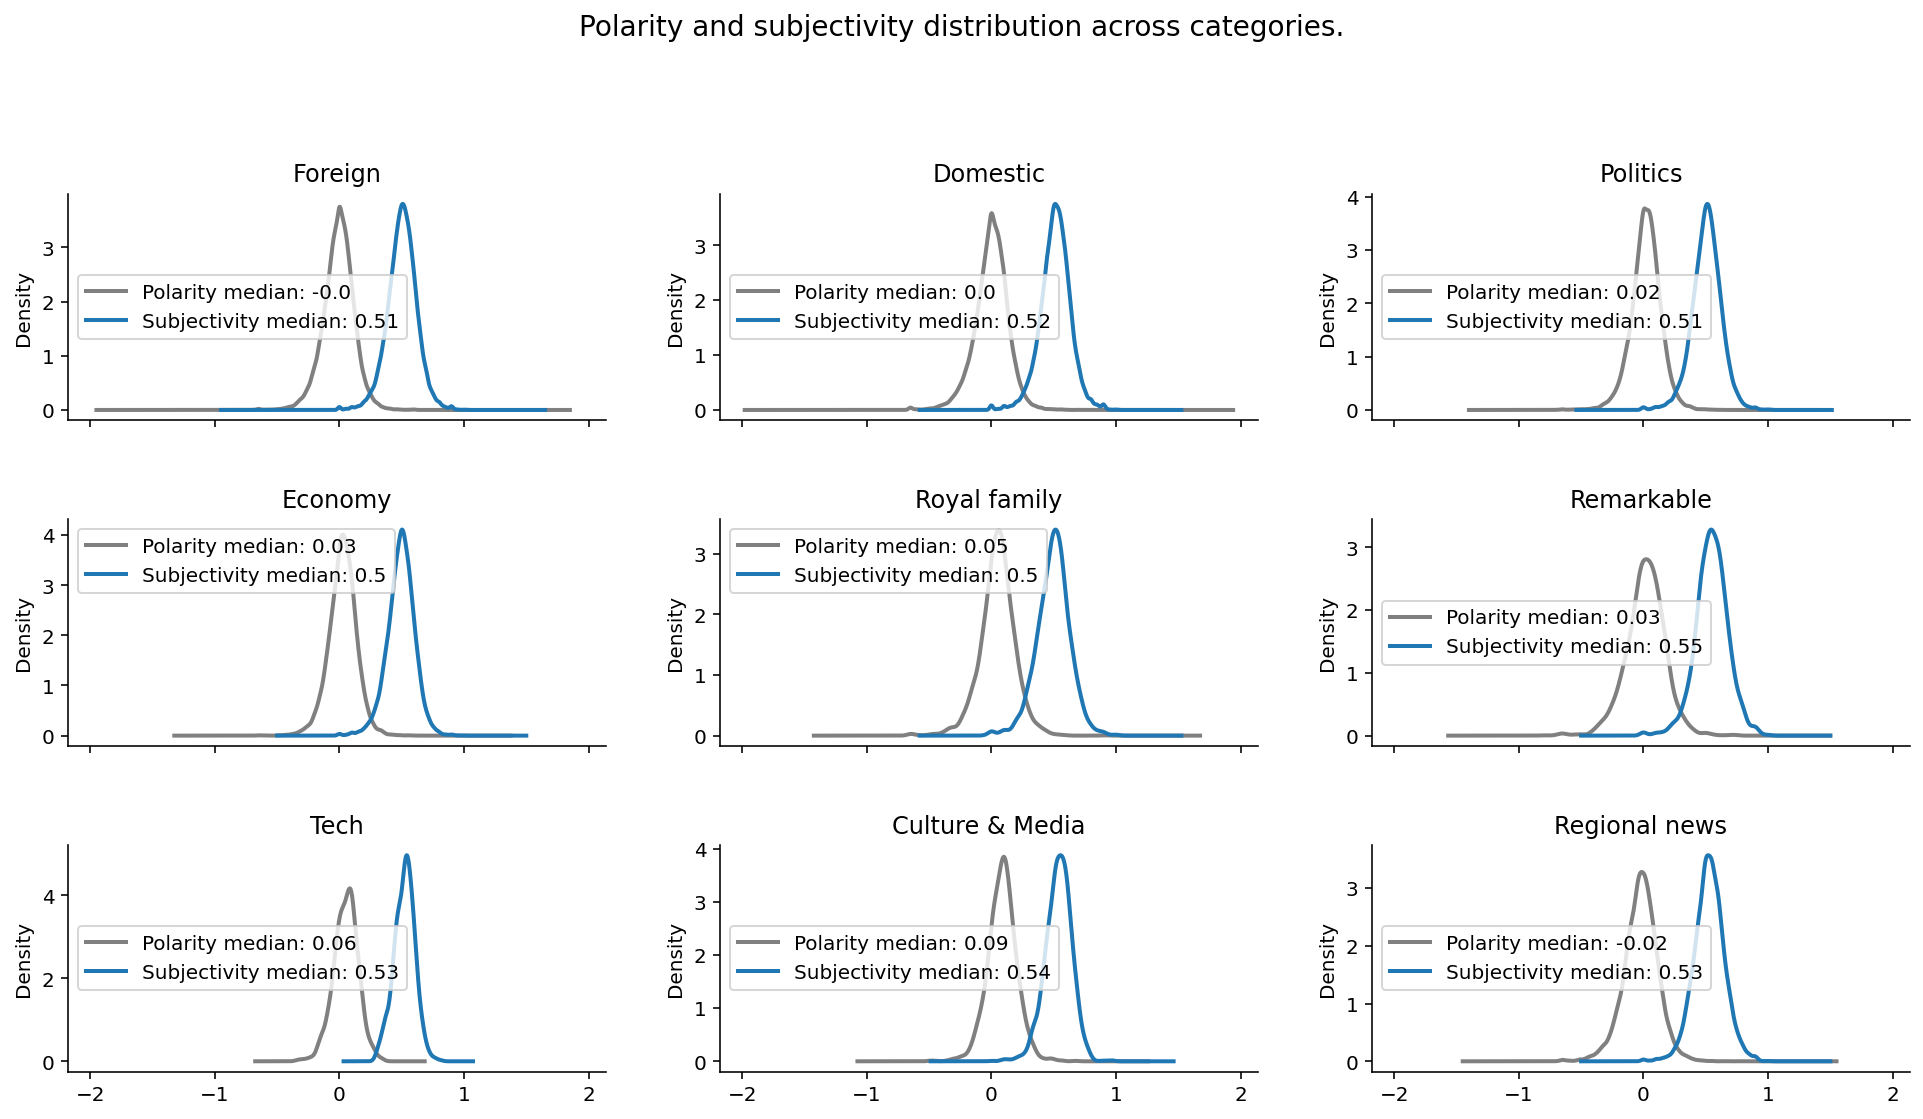

In [35]:
# Initialize plots
fig, axes = plt.subplots(3, 3, figsize=(14, 8), sharex=True)

# Loop over axes and plot category
for cat, ax in enumerate(axes.flatten()):

    # Select df with dataframe
    polarity_category_df = nos_df[nos_df.category_en == categories_en[cat]].polarity
    subjectivity_category_df = nos_df[nos_df.category_en == categories_en[cat]].subjectivity

    # Bar plot word count category
    polarity_category_df.plot(kind="kde", ax=ax, color="gray", lw=2, title=f"{categories_en[cat]}",label=f"Polarity median: {round(polarity_category_df.median(), 2)}")
    subjectivity_category_df.plot(kind="kde", ax=ax, lw=2, label=f"Subjectivity median: {round(subjectivity_category_df.median(), 2)}")
    ax.legend()

# Plot meta data
fig.suptitle("Polarity and subjectivity distribution across categories.", fontsize=TITLE_SIZE, y=1)
fig.tight_layout(pad=3)

sns.despine();

In [ ]:
# nos_df.to_csv("/content/drive/MyDrive/Data/nos_archief_processed.csv", index=None) 
# nos_df.read_csv("/content/drive/MyDrive/Data/nos_archief_processed.csv") 

## Informative words

We can use TF-IDF, short for term frequency-inverse document frequency, to extract the most informative words out of every article. TF-IDF  is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. In this case, I removed stop words, because most of the time they don't contain any useful information. Also, I ignore terms that appear in less than 0.5% of the documents. Let's see if what the most informative terms are in the news articles in every category.

In [28]:
stop_words = list(pd.read_csv("https://raw.githubusercontent.com/stopwords-iso/stopwords-nl/master/stopwords-nl.txt", header=None).values.flatten())

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit TF-IDF vectorizer
tfidf = TfidfVectorizer(min_df=0.005, stop_words=stop_words)
tfidf.fit(nos_df.content);

In [32]:
# transform nos_df article text to tfidf vectors
tfidf_vect = tfidf.transform(nos_df.content)

# Store dataframe
tfidf_df = pd.DataFrame(tfidf_vect.toarray(), columns=tfidf.get_feature_names())

In [33]:
# Insert category column in TF-IDF matrix
tfidf_df['category_en'] = nos_df.category_en

# Get unqiue categories
categories = tfidf_df['category_en'].unique().tolist()

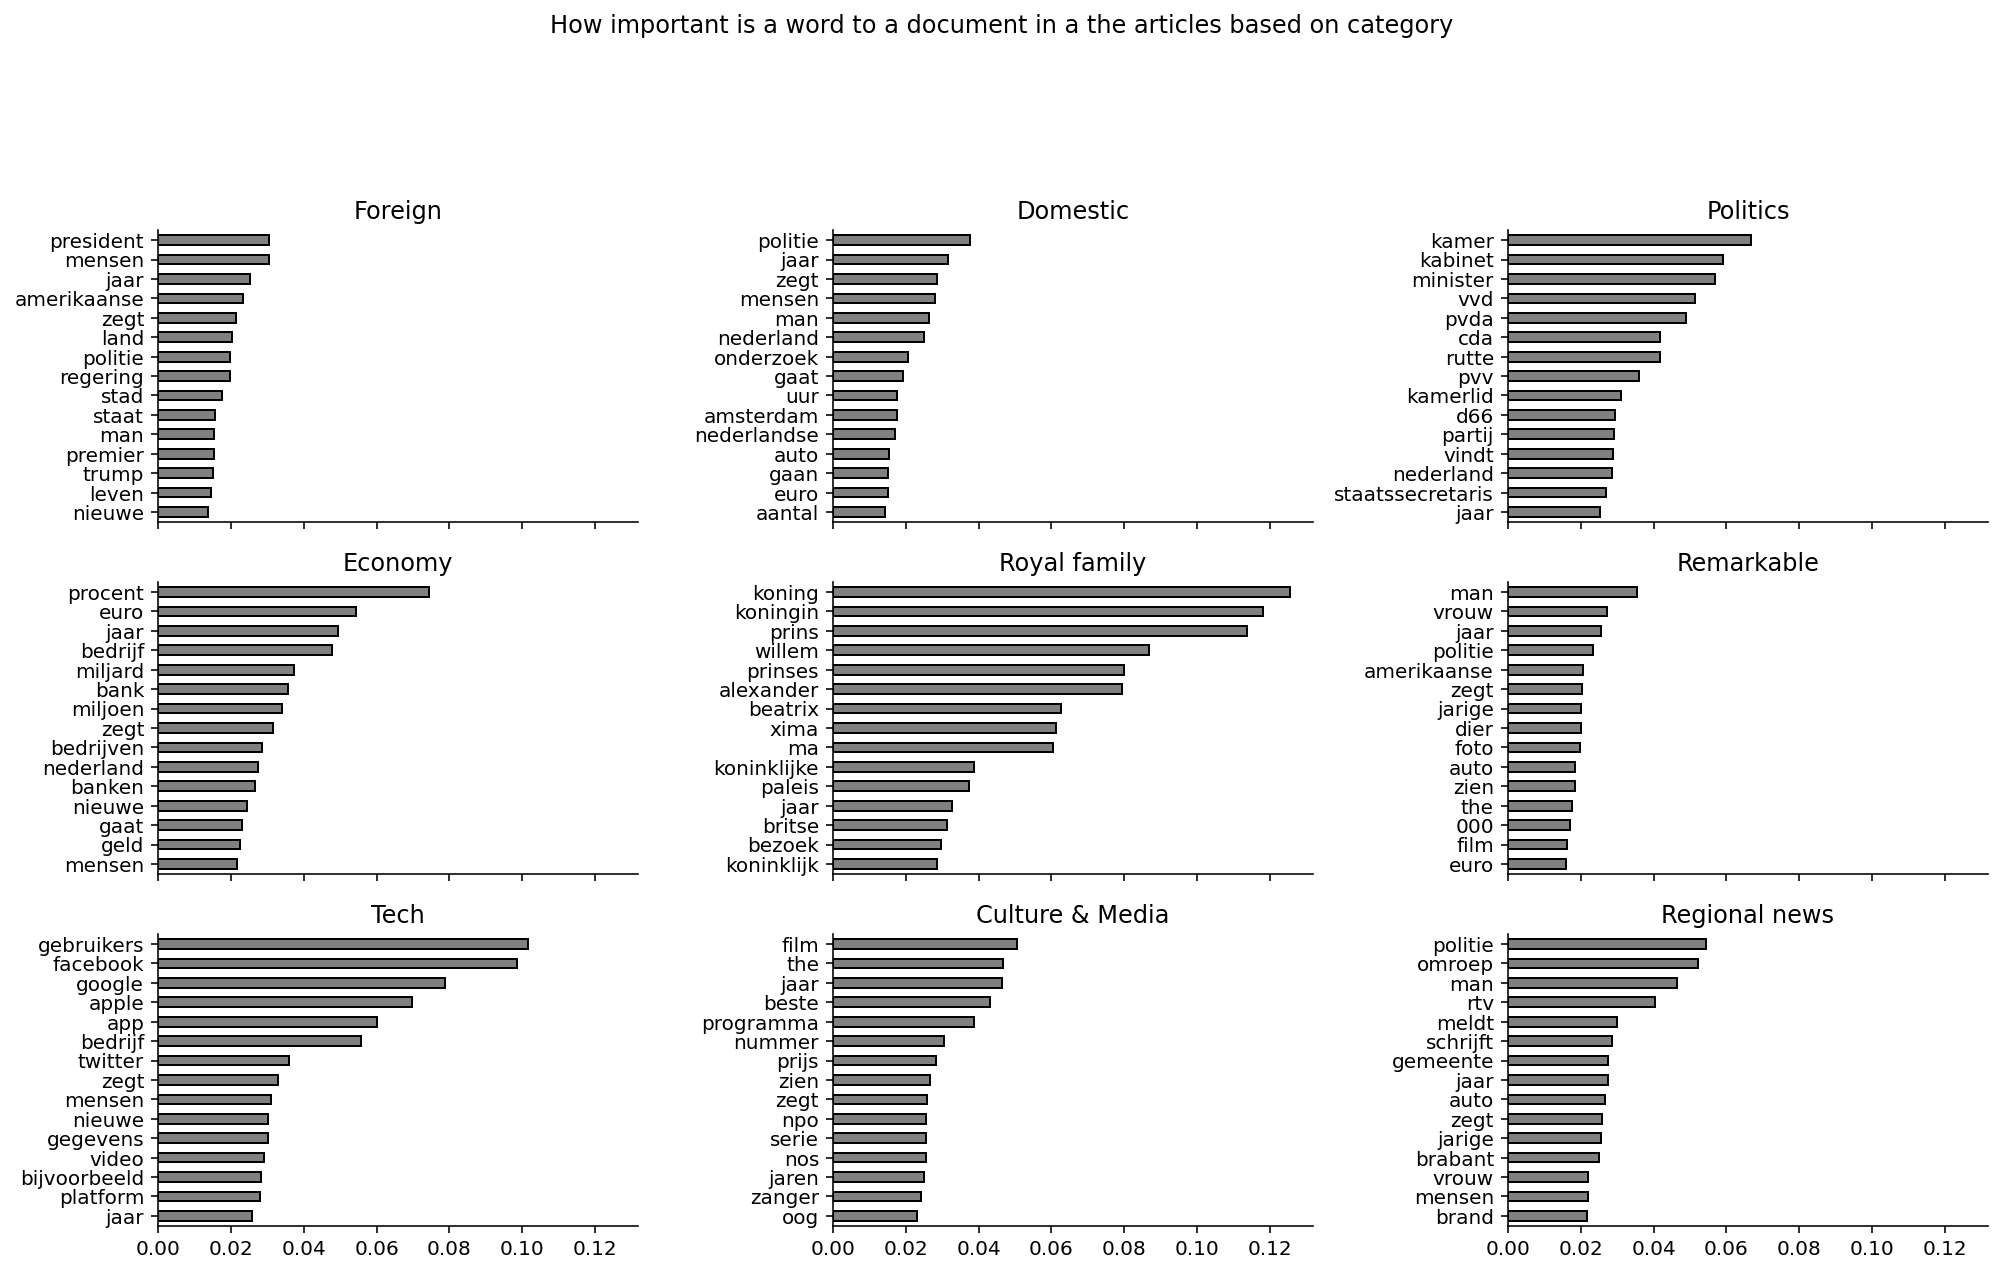

In [34]:
# Initialize plots
fig, axes = plt.subplots(3, 3, figsize=(14, 8), sharex=True)

# Loop over axes and plot category
for cat, ax in enumerate(axes.flatten()):
  
    # Sort words by hight TF-IDF mean and by category
    top = tfidf_df[tfidf_df.category_en == categories[cat]].mean().sort_values().tail(15)

    # Bar plot most imporant words for every category
    top.plot(kind="barh", ax=ax, title=categories[cat], color="gray", edgecolor="k")

# Plot meta data
fig.suptitle("How important is a word to a document in a the articles based on category", y=1.1)
fig.tight_layout()

sns.despine();

The TF-IDF result is pretty interesting. For example, we can see that the most informative terms (translated to English) in articles categorized as politics are: chamber, cabinet, minister, political parties (VVD, PvdA, CDA, D66), member of parliament, and secretary of state. All words that are associated with politics. The most informative terms in the economic news articles are also associated with the economy. For example, percent, Euro, company, billion, banks, and money. In the Royal Family category, we see that the words King, Queen, Prince, Princess, Willem (the king's first name) are all highly informative.

## References

{% bibliography --cited %}